# Online Phase: Indirect Reconstruction

This notebook implements the online phase of the Indirect Reconstruction (IR), firstly proposed in [Introini et al., 2023](https://www.sciencedirect.com/science/article/abs/pii/S0306454922005680), including the following steps:

- Parameter Estimation (PE)
- Proper Orthogonal Decomposition with Interpolation (POD-I)

In [1]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib import cm

from mpi4py import MPI
from dolfinx.io import gmshio
import gmsh
from dolfinx.fem import Function, FunctionSpace
import ufl

from pyforce.tools.backends import LoopProgress
from pyforce.online.indirect_recon import PE
from pyforce.online.pod_interpolation import PODI
from pyforce.tools.functions_list import FunctionsList
from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store

path = './Snapshots/'
path_offline = './Offline_results/'
path_online = './Online_results/'
if not os.path.exists(path_online):
    os.makedirs(path_online)

var_names = ['norm_T', 'p', 'U']
tex_var_names = ['T', 'p', r'\mathbf{u}']

# The temperature is the only one that can be measured
obs_idx = 0

Let us generate the mesh for importing OpenFOAM dataset into *dolfinx*

In [2]:
mesh_comm = MPI.COMM_WORLD
model_rank = 0

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('cavity.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)
gdim = 2

# Linear Finite Element
gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Import into dolfinx
model_rank = 0
domain, ct, ft = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, model_rank, gdim = gdim )
gmsh.finalize()

########################################################################################################

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

Info    : Reading 'cavity.geo'...
Info    : Done reading 'cavity.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000404627s, CPU 0.000531s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Transfinite)
Info    : Done meshing 2D (Wall 0.0422277s, CPU 0.005852s)
Info    : 16384 nodes 32770 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 2.03727e-06s, CPU 1.1e-05s)


Let us define the functional space onto which the OpenFOAM data have been projected; then, the snapshots can be imported.

In [3]:
fun_spaces = [FunctionSpace(domain, ('Lagrange', 1)), FunctionSpace(domain, ('Lagrange', 1)), FunctionSpace(domain, ufl.VectorElement("CG", domain.ufl_cell(), 1))]

train_snaps = dict()
test_snaps  = dict()

training = False

for field_i, field in enumerate(var_names):
    
    if training:
        path_snap = path+'TrainSet_'+field
    else:
        path_snap = path+'TestSet_' +field
    tmp = ImportH5(fun_spaces[field_i], path_snap, field)
    
    if training:
        train_snaps[field] = tmp[0]
    else:
        test_snaps[field] = tmp[0]

Let us import the GEIM magic functions and sensors and the POD modes for non-observable fields

In [4]:
# Magic Functions and Sensors
mf = ImportH5(fun_spaces[obs_idx], path_offline+'BasisFunctions/basisGEIM_'+var_names[obs_idx], 'GEIM_'+var_names[obs_idx])[0]
ms = ImportH5(fun_spaces[obs_idx], path_offline+'BasisSensors/sensorsGEIM_'+var_names[obs_idx], 'GEIM_'+var_names[obs_idx])[0]

# POD modes
pod_modes = dict()
for field_i, field in enumerate(var_names):
    if field_i != obs_idx:
        pod_modes[field] = ImportH5(fun_spaces[field_i], path_offline+'BasisFunctions/basisPOD_'+var_names[field_i], 'POD_'+var_names[field_i])[0]

In the end, let us load the maps of the reduced coefficients and create the test parameters

In [5]:
geim_maps = pickle.load(open(path_offline+'maps.geim', 'rb'))
pod_maps  = pickle.load(open(path_offline+'maps.pod', 'rb'))

dRe = 5.
dRi = 0.4

# Test Parameters
Re_test = np.arange(15+dRe/2,  150+dRe/2, dRe*2)
Ri_test = np.arange(0.2+dRi/2,   5+dRi/2, dRi*2)

Ri, Re = np.meshgrid(Ri_test, Re_test)
mu_test = np.column_stack((Re.flatten(), Ri.flatten()))

## Parameter Estimation

In this section, the measurements of the observable field (temperature in this case) are used to find the characteristic parameter $\boldsymbol{\mu}$, solution of the inverse problem
\begin{equation*}
\boldsymbol{\mu}^\star = \text{arg min}_{\boldsymbol{\mu}\in\mathcal{D}}
\mathcal{L}_{PE}(\boldsymbol{\mu}) = 
\text{arg min}_{\boldsymbol{\mu}\in\mathcal{D}}\|\mathbb{B}\boldsymbol{\beta}(\boldsymbol{\mu}) - \mathbf{y}\|_2^2 \qquad\qquad
\text{ given }\mathcal{F}_m(\boldsymbol{\mu}) = \beta_m(\boldsymbol{\mu})
\end{equation*}
with $\mathbb{B}\in\mathbb{R}^{M\times M}$ a lower triangular matrix, whose components are given by the magic function $q_m$ and sensors $v_m(\cdot)$ as $\mathbb{B}_{mm'} = v_m\left(q_{m'}\right)$.

In [6]:
from pyforce.tools.backends import norms

Mmax = len(ms)

norm = norms(fun_spaces[obs_idx])
matrix_B = np.zeros((Mmax, Mmax))
for mm in range(Mmax):
    for nn in range(Mmax):
        if nn > mm:
            matrix_B[mm, nn] = 0.
        else:
            matrix_B[mm, nn] = norm.L2innerProd(ms(mm), mf(nn))

Now, for each snapshot of the observable field, let us compute the correspondent parameter. The global optimisation is solved in two steps adopting the *scipy* package:

- First Guess using brute force (`brute`) and the differential evolution (`differential_evolution`) solver
- Check using least square solver

In [7]:
map_methods = list(geim_maps[var_names[obs_idx]].keys())

bnds = [(15, 150), (0.2,  5)]

ave_absErr_pe = dict()
ave_relErr_pe = dict()
mu_estimated  = dict()
comput_times  = dict()

pe_data = dict()

for map in map_methods:
        pe_data[map] = PE(matrix_B, geim_maps[var_names[obs_idx]][map], bnds)
        res = pe_data[map].synt_test_error(mu_test, test_snaps[var_names[obs_idx]], ms, Mmax, 
                                        noise_value = 0.01, verbose=True,
                                        use_brute = True, grid_elem = 20)

        ave_absErr_pe[map] = res[0]
        ave_relErr_pe[map] = res[1]
        mu_estimated[map]  = res[2]
        comput_times[map]  = res[4]

Solving Parameter Estimation : 84.000 / 84.00 - 4.240 s/it


Let us plot the errors with respect to the number of measurements

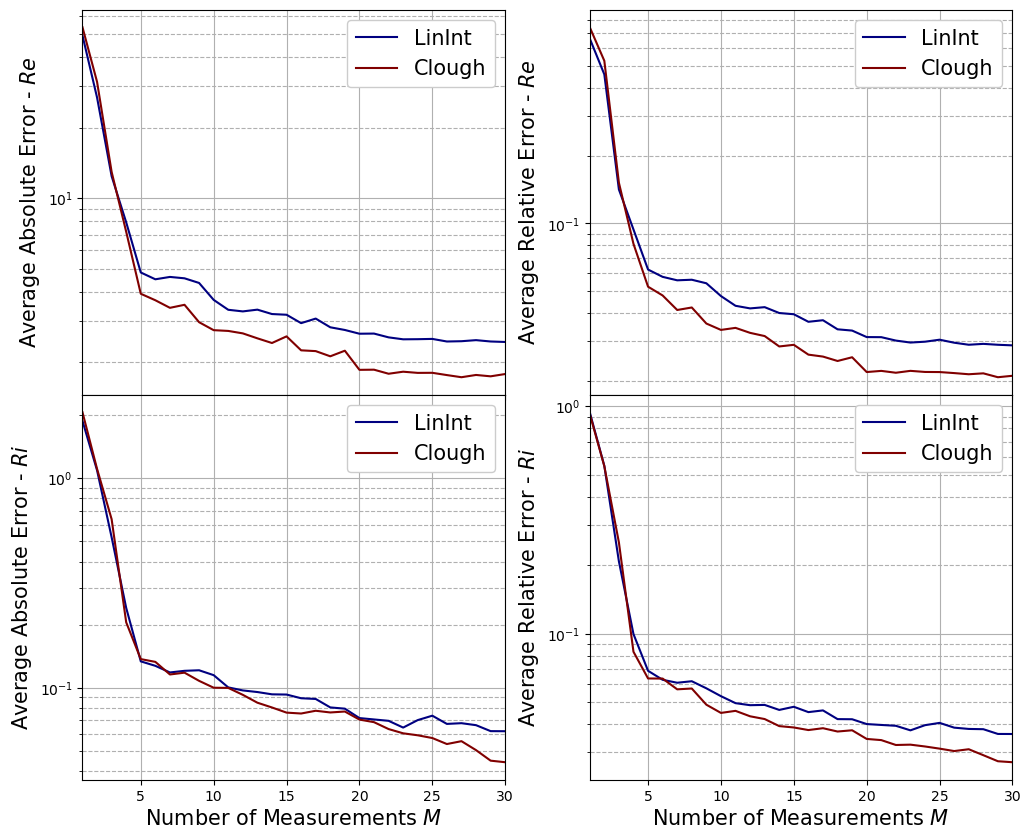

In [8]:
fig, axs = plt.subplots(nrows = mu_test.shape[1], ncols=2, sharex=True, figsize=(6 * 2, 5 * mu_test.shape[1]))

M_to_plot = np.arange(1, Mmax+1, 1)
parameters = [r'$Re$', r'$Ri$']

colors = cm.jet(np.linspace(0, 1, len(map_methods)))
for idx_mu in range(mu_test.shape[1]):
    for ii, map in enumerate(map_methods):
        axs[idx_mu, 0].semilogy(M_to_plot, ave_absErr_pe[map][:, idx_mu], c=colors[ii], label=map)
        axs[idx_mu, 1].semilogy(M_to_plot, ave_relErr_pe[map][:, idx_mu], c=colors[ii], label=map)
        
    for ax_i in range(2):
        axs[idx_mu, ax_i].grid(which='major',linestyle='-')
        axs[idx_mu, ax_i].grid(which='minor',linestyle='--')
        axs[idx_mu, ax_i].legend(framealpha=1, fontsize=15)
        axs[-1, ax_i].set_xlabel('Number of Measurements $M$', fontsize=15)
        axs[idx_mu, ax_i].set_xlim(1, Mmax)
    
    axs[idx_mu, 0].set_ylabel('Average Absolute Error - '+parameters[idx_mu], fontsize=15)
    axs[idx_mu, 1].set_ylabel('Average Relative Error - '+parameters[idx_mu], fontsize=15)

fig.subplots_adjust(hspace=0, wspace=0.2)

## Proper Orthogonal Decomposition with Interpolation (POD-I)
In this section, we are going to use the estimated parameter (using $M_{max}$ measures) to reconstruct the non-observable fields (pressure and velocity) using POD-I.

In [9]:
podi_data = dict()
podi_res  = dict()

Nmax = 20

for field_i, field in enumerate(var_names):
    if field_i != obs_idx:
        podi_data[field] = dict()
        podi_res[field] = dict()

        bar = LoopProgress('POD-I '+field, final = len(map_methods))
        for map in map_methods:
            podi_data[field][map] = PODI(pod_modes[field], pod_maps[field][map], field)

            mu_star = np.array(mu_estimated[map])[:, Mmax-1, :]
            podi_res[field][map] = podi_data[field][map].synt_test_error(test_snaps[field], mu_star, Nmax)
            bar.update(1)
        del bar

POD-I p: 2.000 / 2.00 - 5.111 s/it
POD-I U: 2.000 / 2.00 - 6.848 s/it


Let us plot the reconstruction error

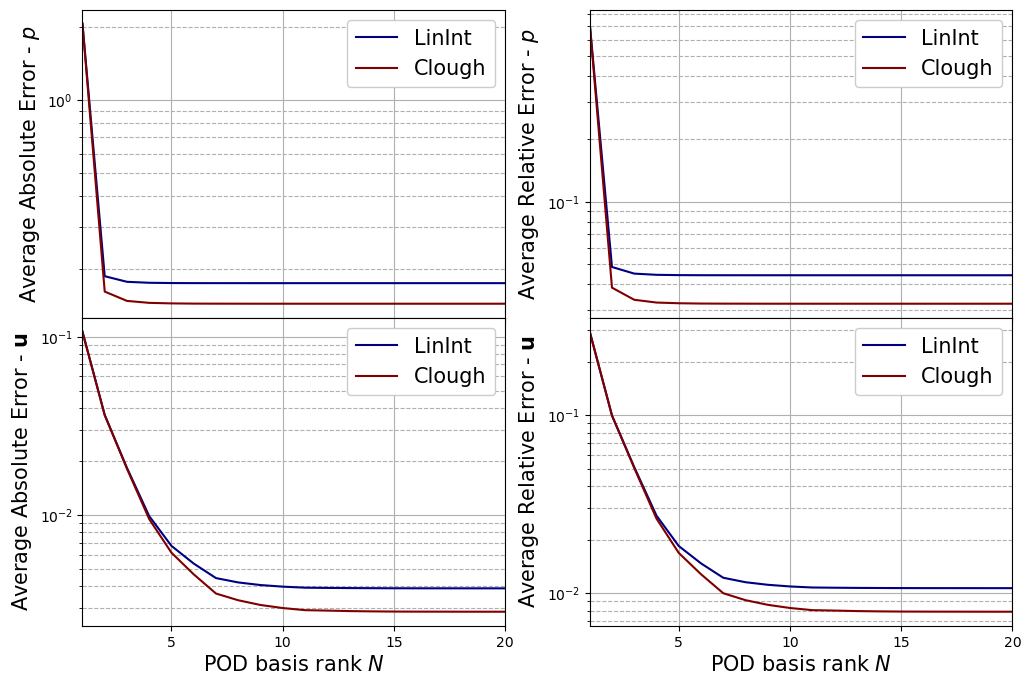

In [10]:
fig, axs = plt.subplots(nrows = len(var_names) - 1, ncols = 2, sharex=True, figsize=(6 * 2, 4 * (len(var_names) - 1)))

N_to_plot = np.arange(1, Nmax+1, 1)
colors = cm.jet(np.linspace(0, 1, len(map_methods)))
for field_i, field in enumerate(var_names):
    
    if field_i != obs_idx:
        for ax_i in range(2):
            for map_i, map in enumerate(map_methods):
                axs[field_i-1, ax_i].semilogy(N_to_plot, podi_res[field][map][ax_i], c=colors[map_i], label=map)
            axs[field_i-1, ax_i].legend(framealpha=1, fontsize=15)
            
            axs[field_i-1, ax_i].grid(which='major',linestyle='-')
            axs[field_i-1, ax_i].grid(which='minor',linestyle='--')
            axs[field_i-1, ax_i].set_xticks(np.arange(0, Nmax+1, 5))
            axs[field_i-1, ax_i].set_xlim(1, Nmax)
            
            axs[-1, ax_i].set_xlabel('POD basis rank $N$', fontsize=15)
            
        axs[field_i-1, 0].set_ylabel('Average Absolute Error - $'+tex_var_names[field_i]+'$', fontsize=15)
        axs[field_i-1, 1].set_ylabel('Average Relative Error - $'+tex_var_names[field_i]+'$', fontsize=15)
        
fig.subplots_adjust(hspace=0, wspace=0.2)

## Post Process

In this last section, we are going to plot the computational times and some contour plots of the non-observable fields.

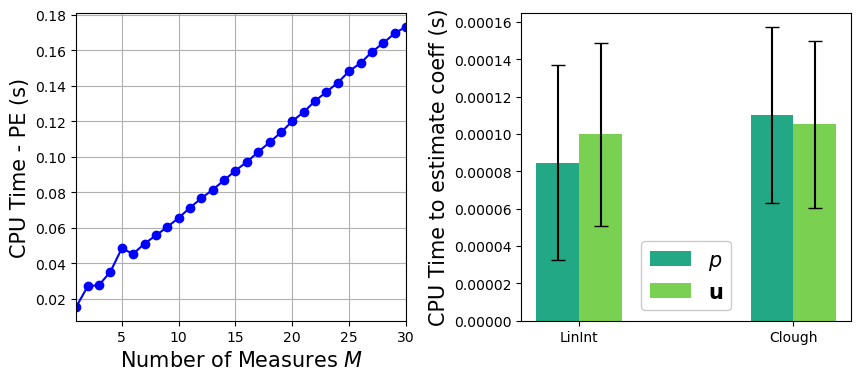

In [12]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10,4))

axs[0].plot(M_to_plot, comput_times['LinInt']['Optimisation'].mean(axis=0), 'b-o')
axs[0].grid()
axs[0].set_xlim(1, Mmax)
axs[0].set_xlabel('Number of Measures $M$', fontsize=15)
axs[0].set_ylabel('CPU Time - PE (s)', fontsize=15)

# Iterate over field_i values
colors = plt.cm.viridis(np.linspace(0.4, 0.8, len(var_names)))  # Choose a colormap
for field_i, color in zip(range(len(var_names)), colors):
    
    if field_i != obs_idx:
        
        means = []
        stds = []

        # Calculate mean and std for each key
        for key in list(podi_res[var_names[field_i]].keys()):
            mean = np.mean(np.mean(podi_res[var_names[field_i]][key][2]['CoeffEstimation'], axis=0))
            std = np.std(np.mean(podi_res[var_names[field_i]][key][2]['CoeffEstimation'], axis=0))
            means.append(mean)
            stds.append(std)

        # Plot the bar chart with error bars for standard deviation
        bar_width = 0.2  # Adjust as needed
        ind = np.arange(len(list(podi_res[var_names[field_i]].keys())))
        bars = axs[1].bar(ind + (field_i - len(var_names) / 2) * bar_width, means, bar_width, label=r'$'+tex_var_names[field_i]+'$', color=color, yerr=stds, capsize=5)

        axs[1].set_ylabel(r'CPU Time to estimate coeff (s)', fontsize=15)
        axs[1].set_xticks(ind)
        axs[1].set_xticklabels(list(podi_res[var_names[field_i]].keys()))
        axs[1].legend(framealpha=1, fontsize=15)
        axs[1].grid()
        
fig.subplots_adjust(wspace=.35)

Lastly, we can plot the reconstructed fields for the non-observable variables

In [13]:
Nmax = 15

reconstructions = dict()

for field_i, field in enumerate(var_names):
    
    if field_i != obs_idx:
        reconstructions[field] = dict()
        
        for key in map_methods:   
            reconstructions[field][key] = FunctionsList(fun_spaces[field_i])
            
        for mu in range(len(test_snaps[field])):
            
            for key in map_methods:
                mu_star = np.array(mu_estimated[map])[:, Mmax-1, :]
                reconstructions[field][key].append(podi_data[field][map].reconstruct(test_snaps[field](mu), mu_star[mu].reshape(-1,2), Nmax)[0])

Here the functions to plot with `pyvista` are implemented.

In [14]:
import vtk
import pyvista as pv
import dolfinx

pv.start_xvfb()

def vector_grids(fun: dolfinx.fem.Function, mag_plot: bool, varname='u'):
    
    topology, cells, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    grid = pv.UnstructuredGrid(topology, cells, geometry)

    values = np.zeros((geometry.shape[0], 3))
    values[:, :len(fun)] = np.real(fun.x.array.reshape(geometry.shape[0], len(fun)))
    grid[varname] = values

    if mag_plot:
        warped = grid.warp_by_vector(varname, factor=0.0) 
    else:
        warped = grid.glyph(varname, factor=0.15, tolerance=0.02)
        
    return warped, values

def grids(fun: dolfinx.fem.Function):
    topology, cell_types, geometry = dolfinx.plot.create_vtk_mesh(fun.function_space)
    u_grid = pv.UnstructuredGrid(topology, cell_types, geometry)
    u_grid.point_data['fun'] = fun.x.array[:].real
    u_grid.set_active_scalars('fun')
    return u_grid

Here we define the plotting function

In [15]:
def PlotFOM_vs_ROM( fom: FunctionsList, rom: dict, mu: int, title: str, varname: str,
                    clim = None, mag_plot = True, colormap = cm.jet, 
                    colormap_res = cm.plasma_r, clim_res = None,
                    filename = None):  
    
    keys = list(rom.keys())
    
    resolution = [900 * ( len(keys) + 1), 900 * 2]
    plotter = pv.Plotter(shape=(2, len(keys)+1), off_screen=False, border=False, window_size=resolution)
    
    lab_fontsize = 20
    title_fontsize = 30
    zoom = 1.05
    
    dict_cb = dict(title = varname, width = 0.75, height = 0.1,
                    title_font_size=title_fontsize,
                    label_font_size=lab_fontsize,
                    n_labels=3,
                    color = 'k',
                    position_x=0.125, position_y=0.885,
                    shadow=False) 
    
    if fom.fun_space.num_sub_spaces > 0:
        vector_plot = True
    else:
        vector_plot = False
    
    ############################ FOMs ###################################

    plotter.subplot(0,0)
    
    if vector_plot:
        warped_fom, values_fom = vector_grids(fom.map(mu), mag_plot, varname=varname)
        if clim is None:
            clim = [0., max(np.sqrt(values_fom[:, 0]**2+values_fom[:, 1]**2+values_fom[:, 2]**2))]
    else:
        warped_fom = grids(fom.map(mu))
        if clim is None:
            clim = [min(fom(mu)), max(fom(mu))]
        
    dict_cb['title'] = 'FOM - $'+varname+'$'
    plotter.add_mesh(warped_fom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
    plotter.view_xy()
    plotter.camera.zoom(zoom)

    ############################ ROMs ###################################


    for key_i in range(len(keys)):
        plotter.subplot(0, 1+key_i)
        
        # rom[keys[key_i]]._list[mu] = rom[keys[key_i]]._list[mu] * (umax - umin) + umin
    
        if vector_plot:
            warped_rom, _ = vector_grids(rom[keys[key_i]].map(mu), mag_plot, varname=varname)
        else:
            warped_rom = grids(rom[keys[key_i]].map(mu))
        
        dict_cb['title'] = 'POD-I '+keys[key_i]+' - $'+varname+'$'
        dict_cb['n_labels'] = 2
        plotter.add_mesh(warped_rom, clim = clim, cmap = colormap, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)

    ############################ Residuals ###################################

    max_res = 0.
    for key_i in range(len(keys)):
        plotter.subplot(1, 1+key_i)
        
        residual = dolfinx.fem.Function(rom[keys[key_i]].fun_space)
        residual.x.array[:] = np.abs(rom[keys[key_i]](mu) - fom(mu))

        max_res = max([max_res, max(residual.x.array[:])])
        
        if vector_plot:
            warped_rom, _ = vector_grids(residual, mag_plot, varname=varname)
        else:
            warped_rom = grids(residual)
        
        if clim_res is None:
            clim_res = [0, max_res]
        
        dict_cb['title'] = 'Residual POD-I '+keys[key_i]+' - $'+varname+'$'
        plotter.add_mesh(warped_rom, clim = clim_res, cmap = colormap_res, show_edges=False, scalar_bar_args=dict_cb)
        plotter.view_xy()
        plotter.camera.zoom(zoom)


    plotter.set_background('white', top='white')
    plotter.subplot(1,0)
    plotter.add_text(str(title), color= 'k', position=[150, 500], font_size=30)
    
    if filename is None:
        plotter.show()
    else:
        ## Save figure
        plotter.screenshot(filename+'.png', transparent_background = True,  window_size=resolution)
        plotter.close()

In the end, the figure can be generated

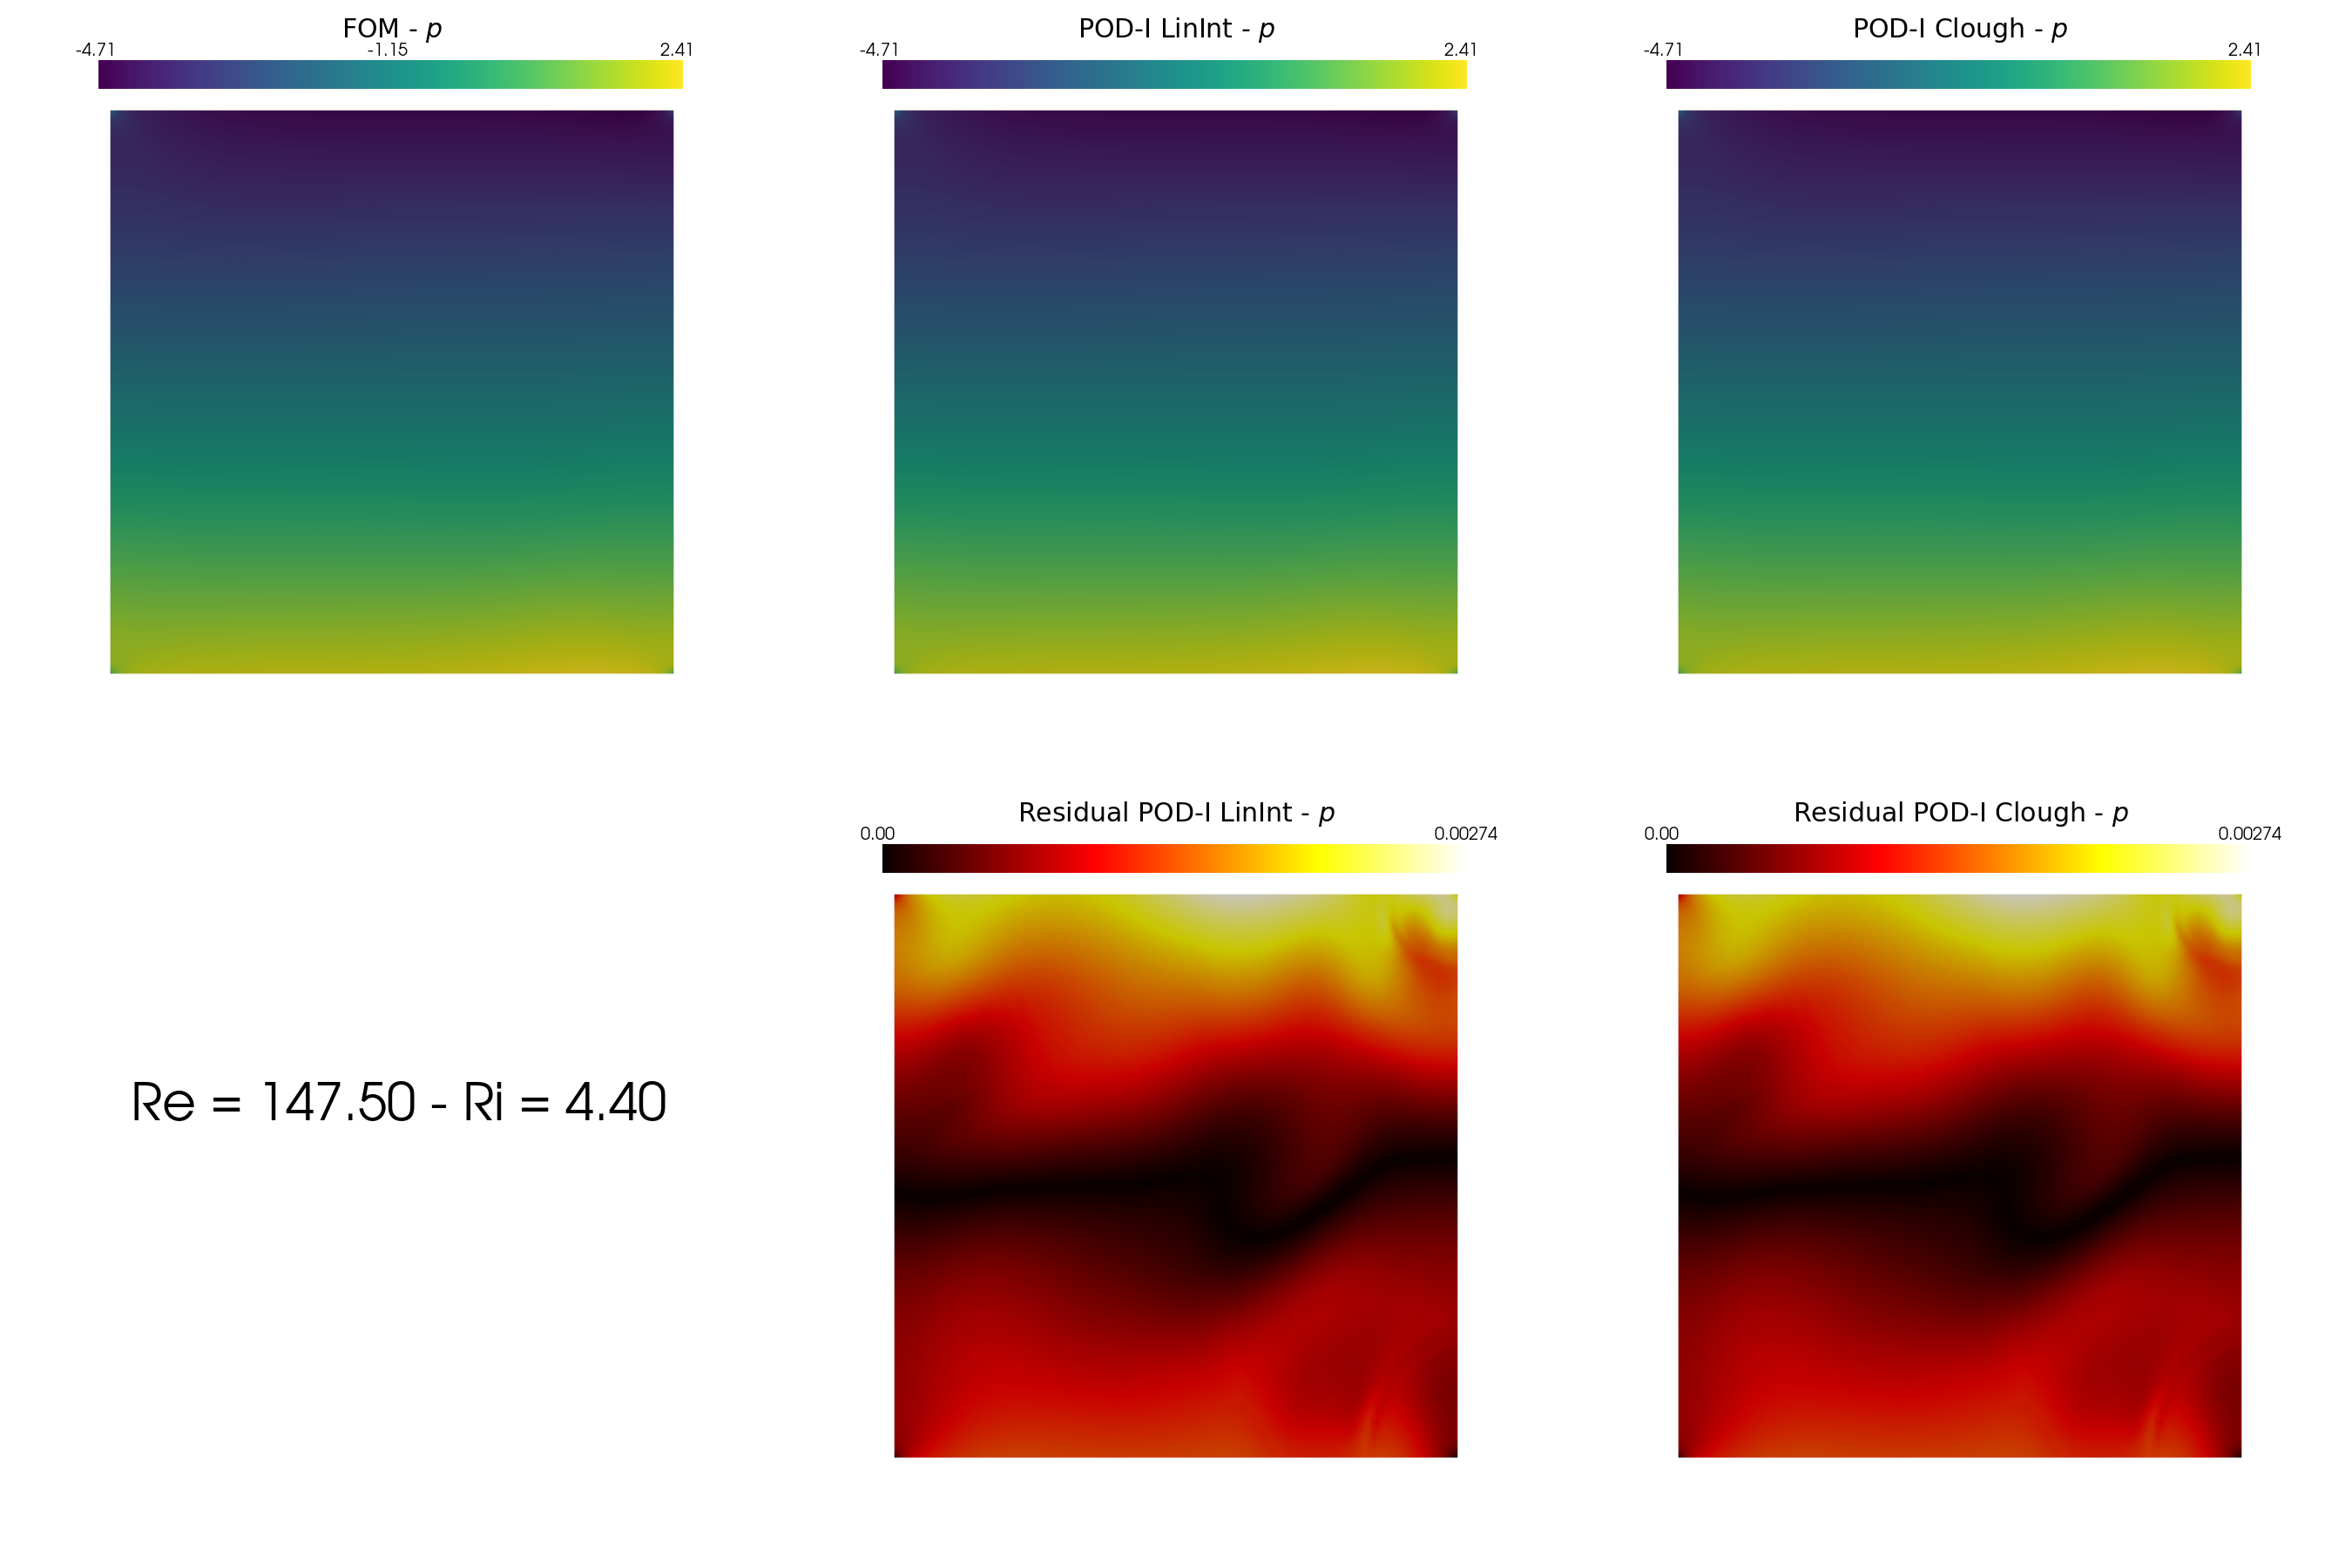


No module named 'trame'

Falling back to a static output.
  warnings.warn(



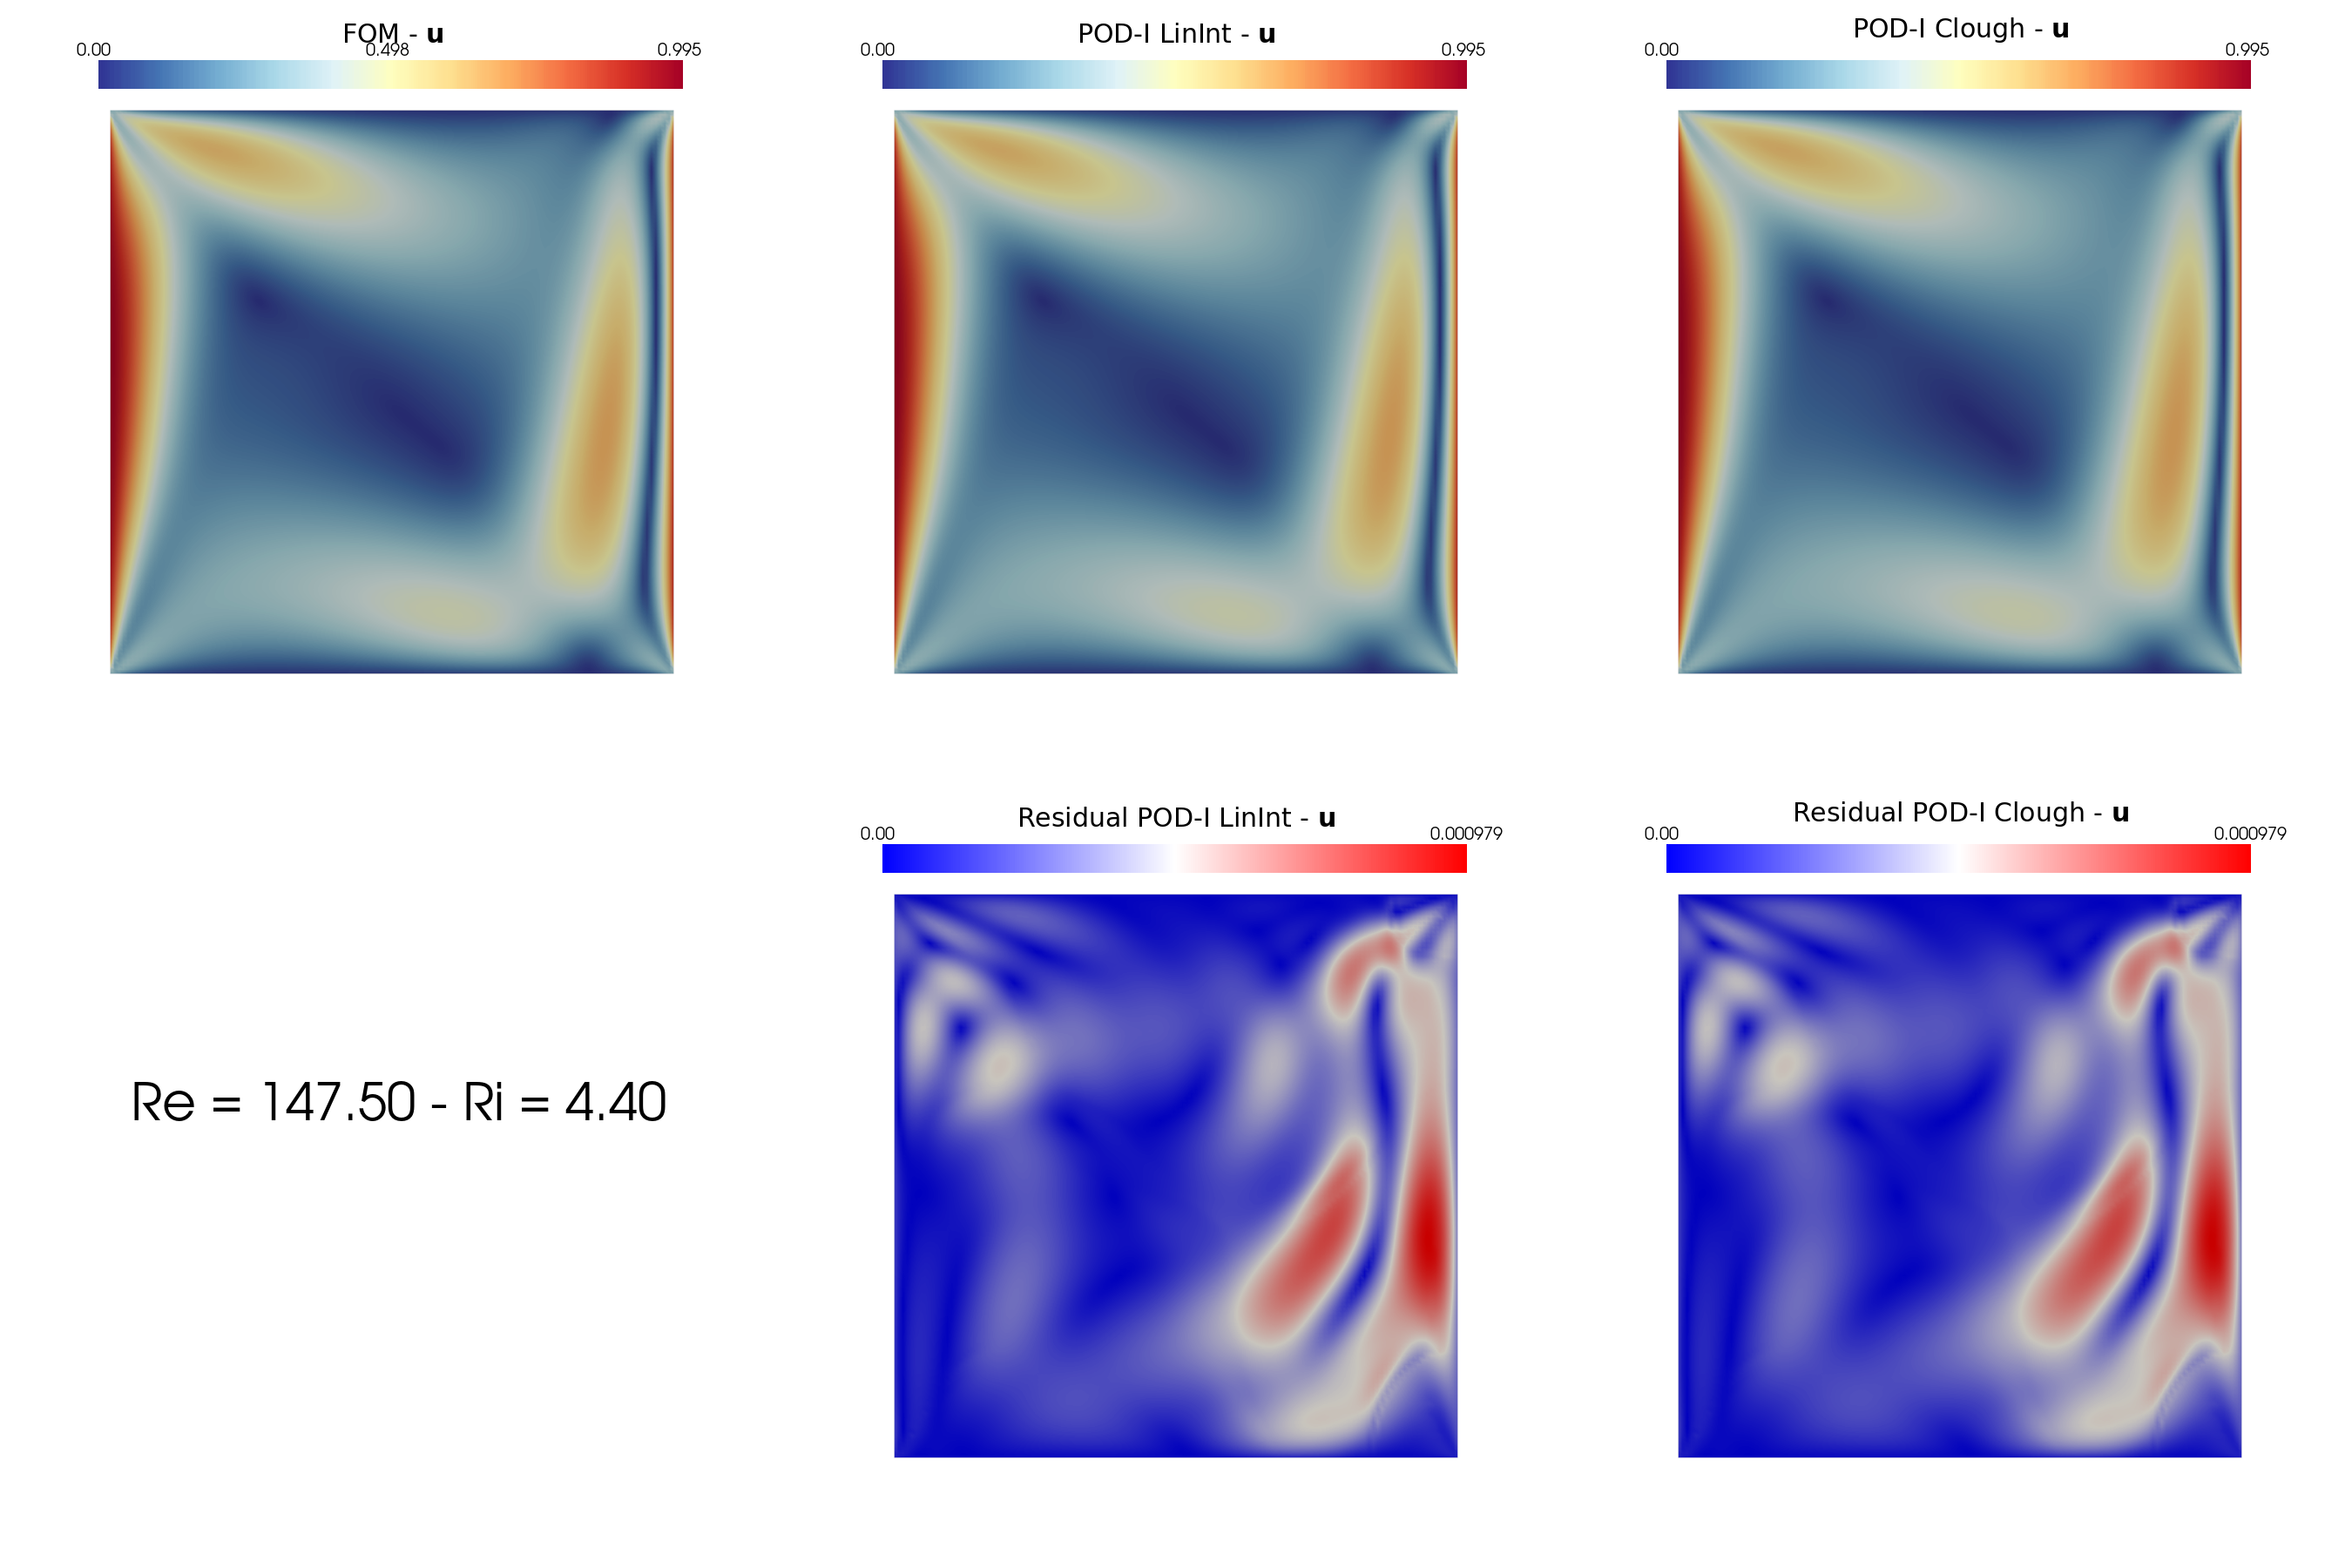

In [16]:
cmaps = [cm.viridis, cm.RdYlBu_r]
cmaps_res = [cm.hot, cm.bwr]

for field_i, field in enumerate(var_names):
    if field_i != obs_idx:
        # bar = LoopProgress('Plotting '+var_names[field_i], final = len(test_snaps[field]))
        
        mu_plot = -1
        title = 'Re = {:.2f}'.format(mu_test[mu_plot, 0])+' - Ri = {:.2f}'.format(mu_test[mu_plot, 1])

        PlotFOM_vs_ROM( test_snaps[field], reconstructions[field], 
                        mu_plot, title, tex_var_names[field_i],
                        colormap=cmaps[field_i-1], colormap_res = cmaps_res[field_i-1],
                        filename=None
                        )